<a href="https://colab.research.google.com/github/AshOne91/PLAYDATA-COLAB/blob/main/CNN_RNN_GAN_DIFUSSION_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN

강화학습
```
에이전트(agent)가 환경(Environment)과 상화작용하며 보상(Reward)을 최대화 하는 정책(Policy)을 학습
환경 : 학습이 이루어지는 공간(게임, 시뮬레이션)
에이전트 : 환경에서 행동을 선택하는 주체
행동 : 에이전트가 환경에 맞게 취할수 있는 행동(왼쪽/오른쪽)
보상 : 행동에따라서 환경이 제공하는 평가값(목표달성시 양의값)
```

In [ ]:
!pip install torch torchvision gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

환경
```
OpenAI Gym CartPole 환경
막대가 넘어지지 않도록 균형을 유지
```

In [ ]:
import gym
env = gym.make('CartPole-v1',new_step_api=True)  # 최신버전에 맞춰 반환값 형식을 사용
state = env.reset() # 초기 상태 설정
# 수레의 위치, 수레의 속도, 막대의 기울기, 막대기울기의 속도
state

array([-0.04852097,  0.01142589,  0.04226405, -0.0420718 ], dtype=float32)

In [ ]:
action = env.action_space.sample() # 무작위 행동 0또는 1
#
# 선택된 행동, 다음상태, 보상, 종료여부,강제종료여부
env.step(action)

(array([-0.04417411,  0.01023049,  0.03500009, -0.01567327], dtype=float32),
 1.0,
 False,
 False,
 {})

신경망(Policy Network)정의
```
에이전트가 행동을 선택하기 위해 사용하는 간단한 신경망을 정의
에이전트가 주어진 환경에서 어떤 행동을 할지 확률적으로 결정하는 신경망
```

In [ ]:
class PolicyNetwork(nn.Module):
  def __init__(self,input_dim,output_dim):  # input_dim catPol 은 4개 output_dim:가능한 행동의수 2(왼쪽오른쪽)
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, output_dim),
        nn.Softmax(dim=-1) # 마지막 차원을 기준으로 해서 softmax적용(행동 선택용 확률)
    )
  def forward(self,x):
    return self.fc(x)
state_dim = env.observation_space.shape[0]  # 상태 차원
action_dim = env.action_space.n  # 행동 차원
# state_dim
# 수레의 위치, 수레의 속도, 막대의 기울기, 막대기울기의 속도
# x, x_dot, theta,theta_dot
print(state_dim, action_dim )


4 2


정책 네트워크 및 옵티마이져  설정

In [ ]:
policy_net = PolicyNetwork(state_dim,action_dim)
optimizer = optim.Adam(policy_net.parameters(), lr= 1e-4)

에이전트 행동 학습
```
에이전트가 환경에서 행동을 선택하고, 보상받고, 보상에 따라 정책을 학습하는 구조

reinforce 수식
보상이 높으면 그행동을 강화하고 낮으면 억제
```
$$\mathcal{L}(\theta) = - \sum_{t=0}^{T} \log \pi_{\theta}(a_t \mid s_t) \cdot R_t$$

$$\mathcal{L}(\theta) 손실함수 $$

$$\log \pi_{\theta}(a_t \mid s_t) : 정책 네트워크가 s_t 상태에서 a_t 행동을 선택할 확률(파라메터 \theta에의해서 결정)$$

$$R_t: t시간 이후 얻을 누적 보상$$
T : 에피소드 종료

In [ ]:
import torch
def select_action(state):
  state = torch.tensor(state, dtype = torch.float32)
  action_probs = policy_net(state)
  action = torch.distributions.Categorical(action_probs).sample() # 확률에 따라서 0또는 1을 선택
  return action.item()
# 학습루프  episode : 폴대가 넘어질때까지
total_reward = 0
rewards_lists = []
for episode in range(500):
  # 상태 초기화
  state = env.reset()
  rewards = []
  log_probs = [] # 정책확률을 저장 --> gradient 계산에 필요
  while True:
    # 에이전트가 행동 선택
    action = select_action(state)
    # 환경과 상호작용: 행동을 선택하고 step을 통해 다음상태,보상등을 받음
    next_step, reward, terminated,truncated,info = env.step(action)  # done이 Ture이면 에피소드 종료
    done = terminated or truncated
    # 보상과 행동의 확률을 저장
    rewards.append(reward)
    log_prob = torch.log(policy_net(torch.tensor(state, dtype=torch.float32))[action])
    log_probs.append(log_prob)
    total_reward += reward
    state = next_step
    if done:
      break
  # 손실 계산 정책 업데이트  reinforce
  # reward를 곱해주고 있음
  rewards_lists.append(sum(rewards))
  loss = -sum([ log_prob*reward for log_prob,reward in zip(log_probs,rewards)  ])
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  print(f"episode {episode+1} total reward = {total_reward}")


episode 1 total reward = 22.0
episode 2 total reward = 61.0
episode 3 total reward = 77.0
episode 4 total reward = 105.0
episode 5 total reward = 122.0
episode 6 total reward = 138.0
episode 7 total reward = 165.0
episode 8 total reward = 175.0
episode 9 total reward = 191.0
episode 10 total reward = 205.0
episode 11 total reward = 226.0
episode 12 total reward = 236.0
episode 13 total reward = 252.0
episode 14 total reward = 266.0
episode 15 total reward = 277.0
episode 16 total reward = 302.0
episode 17 total reward = 314.0
episode 18 total reward = 330.0
episode 19 total reward = 340.0
episode 20 total reward = 351.0
episode 21 total reward = 362.0
episode 22 total reward = 375.0
episode 23 total reward = 390.0
episode 24 total reward = 403.0
episode 25 total reward = 442.0
episode 26 total reward = 461.0
episode 27 total reward = 501.0
episode 28 total reward = 510.0
episode 29 total reward = 525.0
episode 30 total reward = 553.0
episode 31 total reward = 565.0
episode 32 total rew

보스턴 주택 가격을 강화학습으로
```
환경 설계
  상태 : 주택의 특성(방개수,범죄율, 인구밀도)
  행동 : 가격조정(상승/하락)
  보상 : 실제가격과 예측 가격의 차이
```

환경 클래스

In [ ]:
import gymnasium as gym
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import random

class BostonHousingEnv(gym.Env):
    def __init__(self):
        super(BostonHousingEnv, self).__init__()

        # 캘리포니아 주택 데이터셋 로드
        california = fetch_california_housing()
        self.data = california.data
        self.target = california.target

        # 특성 스케일링
        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(self.data)

        # 타겟 스케일링
        self.target_scaler = StandardScaler()
        self.target = self.target_scaler.fit_transform(self.target.reshape(-1, 1)).flatten()

        # 환경 파라미터 설정
        self.state_size = self.data.shape[1]  # 특성의 수
        self.current_idx = 0

        # 관측 공간 정의 (각 특성의 범위는 스케일링된 값의 범위로 설정)
        self.observation_space = gym.spaces.Box(
            low=np.min(self.data, axis=0).astype(np.float32),
            high=np.max(self.data, axis=0).astype(np.float32),
            dtype=np.float32
        )

        # 행동 공간 정의 (가격 조정값)
        self.action_space = gym.spaces.Box(
            low=np.array([-1.0], dtype=np.float32),
            high=np.array([1.0], dtype=np.float32),
            shape=(1,),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        # 랜덤한 데이터 포인트 선택
        self.current_idx = random.randint(0, len(self.data) - 1)
        return self.data[self.current_idx].astype(np.float32), {}

    def step(self, action):
        # 현재 상태에서의 실제 가격
        actual_price = self.target[self.current_idx]

        # 행동을 가격 조정값으로 변환
        price_adjustment = action[0]

        # 예측 가격 계산
        predicted_price = actual_price + price_adjustment

        # 보상 계산 (예측 오차의 음수값)
        error = abs(predicted_price - actual_price)
        reward = -error

        # 다음 상태로 이동
        self.current_idx = (self.current_idx + 1) % len(self.data)
        next_state = self.data[self.current_idx].astype(np.float32)

        # 에피소드 종료 조건
        done = self.current_idx == 0

        # 정보
        info = {
            'actual_price': actual_price,
            'predicted_price': predicted_price,
            'error': error
        }

        return next_state, reward, done, False, info

    def render(self):
        # 현재 상태 출력
        print(f"Current State: {self.data[self.current_idx]}")
        print(f"Actual Price: {self.target[self.current_idx]:.2f}")

    def inverse_transform_price(self, price):
        # 스케일링된 가격을 원래 스케일로 변환
        return self.target_scaler.inverse_transform([[price]])[0][0]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

# DQN 신경망 클래스 정의
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        # 3개의 완전 연결 레이어로 구성된 신경망
        # 입력층: 환경의 상태(13개 특성)를 받아들임
        # 은닉층: 128개의 뉴런으로 구성된 2개의 레이어
        # 출력층: 연속적인 행동값(가격 조정)을 출력
        self.fc1 = nn.Linear(input_size, 128)    # 입력층 -> 은닉층1
        self.fc2 = nn.Linear(128, 128)           # 은닉층1 -> 은닉층2
        self.fc3 = nn.Linear(128, output_size)   # 은닉층2 -> 출력층
        self.relu = nn.ReLU()
    def forward(self, x):
        # 순전파 과정: ReLU 활성화 함수 사용
        # ReLU는 음수값을 0으로 만들고 양수값은 그대로 유지
        # 이는 신경망의 표현력을 높이고 기울기 소실 문제를 완화
        x = self.relu(self.fc1(x))  # 첫 번째 은닉층 통과
        x = self.relu(self.fc2(x))  # 두 번째 은닉층 통과
        return self.fc3(x)           # 출력층 통과 (Q-value 반환)

# 경험 재생 버퍼 클래스  : 메모리 구조
class ReplayBuffer:
    def __init__(self, capacity):
        # 최대 크기가 capacity인 deque로 버퍼 초기화
        # deque는 양쪽 끝에서 빠른 삽입/삭제가 가능한 자료구조
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # 새로운 경험을 버퍼에 저장
        # (상태, 행동, 보상, 다음 상태, 종료 여부) 튜플로 저장
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # 버퍼에서 무작위로 batch_size개의 경험을 샘플링
        # 무작위 샘플링은 경험 간의 상관관계를 깨뜨려 학습 안정성 향상
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        # 현재 버퍼에 저장된 경험의 수 반환
        return len(self.buffer)

# DQN 에이전트 클래스
class DQNAgent:
    def __init__(self, state_size, action_size):
        # 환경의 상태와 행동 공간 크기 저장
        self.state_size = state_size
        self.action_size = action_size

        # 경험 재생 버퍼 초기화 (최대 10000개의 경험 저장)
        # 충분한 크기의 버퍼는 다양한 경험을 저장하고 학습의 안정성 향상
        self.memory = ReplayBuffer(10000)

        # 강화학습 하이퍼파라미터 설정
        self.gamma = 0.99    # 미래 보상의 할인율 (즉각적인 보상 vs 미래 보상의 균형)
        self.epsilon = 1.0   # 탐험률 (초기값 1.0: 완전한 무작위 탐험)
        self.epsilon_min = 0.01  # 최소 탐험률 (학습이 진행되어도 일정 수준의 탐험 유지)
        self.epsilon_decay = 0.995  # 탐험률 감소율 (학습이 진행될수록 탐험을 줄임)
        self.learning_rate = 0.001  # 학습률 (가중치 업데이트의 크기)
        self.batch_size = 64  # 배치 크기 (한 번에 학습하는 경험의 수)

        # 정책 네트워크와 타겟 네트워크 초기화
        # 정책 네트워크: 현재 정책을 학습
        # 타겟 네트워크: 정책 네트워크의 가중치를 주기적으로 복사하여 학습의 안정성 향상
        self.policy_net = DQN(state_size, action_size)
        self.target_net = DQN(state_size, action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Adam 옵티마이저 초기화
        # Adam은 적응적 학습률을 사용하여 학습 속도와 안정성을 개선
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    def select_action(self, state):
        # ε-greedy 정책으로 행동 선택
        if random.random() < self.epsilon:
            # 탐험: 무작위 행동 선택 (-1에서 1 사이의 값)
            # 초기에는 무작위 탐험을 통해 다양한 경험 축적
            return np.random.uniform(-1, 1, size=(self.action_size,))

        # 활용: 현재 정책에 따라 최적의 행동 선택
        # 학습이 진행될수록 신경망의 예측을 더 신뢰
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.policy_net(state)
            return q_values.numpy()[0]  # [0]을 추가하여 1차원 배열로 변환

    def train(self):
        # 배치 크기보다 작으면 학습하지 않음
        # 충분한 경험이 쌓일 때까지 기다림
        if len(self.memory) < self.batch_size:
            return

        # 경험 재생 버퍼에서 배치 샘플링
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # 텐서 변환 수정
        states = torch.FloatTensor(np.vstack(states))
        actions = torch.FloatTensor(np.vstack(actions))
        rewards = torch.FloatTensor(np.array(rewards))
        next_states = torch.FloatTensor(np.vstack(next_states))
        dones = torch.FloatTensor(np.array(dones))

        # 현재 Q-value 계산
        current_q_values = self.policy_net(states)

        # 다음 상태의 최대 Q-value 계산
        # 타겟 네트워크를 사용하여 학습의 안정성 향상
        next_q_values = self.target_net(next_states).max(1)[0].detach()

        # 타겟 Q-value 계산 (Bellman 방정식)
        # 현재 보상 + 미래 보상의 할인값 : 학습의 안정성 을 위해서 일반적인 reinforce 방식에서 개선
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # MSE 손실 계산
        # 현재 Q-value와 타겟 Q-value의 차이를 최소화
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)

        # 역전파 및 가중치 업데이트
        self.optimizer.zero_grad()  # 기울기 초기화
        loss.backward()            # 역전파
        self.optimizer.step()      # 가중치 업데이트

        # 탐험률 감소
        # 학습이 진행될수록 무작위 탐험을 줄이고 학습된 정책을 더 신뢰
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        # 타겟 네트워크를 정책 네트워크의 가중치로 업데이트
        # 주기적인 업데이트로 학습의 안정성 향상
        self.target_net.load_state_dict(self.policy_net.state_dict())

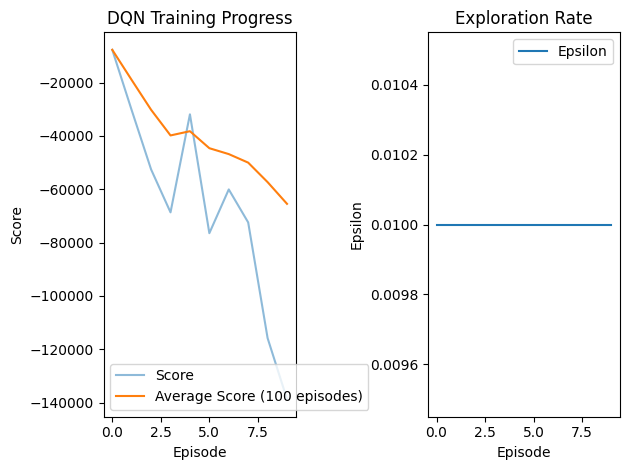

Episode: 9
Score: -138722.23
Average Score (last 100): -65442.69
Best Average Score: -7676.98
Epsilon: 0.01
--------------------------------------------------

=== Inference Results ===

Sample 1:
Actual Price: $2.59
Predicted Price: $-4.40
Error: $7.00

Sample 2:
Actual Price: $1.64
Predicted Price: $-26.92
Error: $28.55

Sample 3:
Actual Price: $2.73
Predicted Price: $-2.91
Error: $5.65

Sample 4:
Actual Price: $2.18
Predicted Price: $-3.28
Error: $5.46

Sample 5:
Actual Price: $1.53
Predicted Price: $-0.53
Error: $2.06

Sample 6:
Actual Price: $2.83
Predicted Price: $-30.21
Error: $33.03

Sample 7:
Actual Price: $2.06
Predicted Price: $1.01
Error: $1.06

Sample 8:
Actual Price: $1.08
Predicted Price: $-6.12
Error: $7.21

Sample 9:
Actual Price: $4.02
Predicted Price: $-5.09
Error: $9.11

Sample 10:
Actual Price: $0.84
Predicted Price: $-5.92
Error: $6.76

Average Error: $10.59


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import os

def train_agent(save_path='boston_dqn_model.pth'):
    # 환경 생성
    # BostonHousingEnv는 보스턴 주택 데이터를 강화학습 환경으로 변환
    env = BostonHousingEnv()

    # 에이전트 초기화
    # state_size: 13 (주택 특성의 수)
    # action_size: 1 (가격 조정값)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    agent = DQNAgent(state_size, action_size)

    # 학습 파라미터 설정
    episodes = 10          # 총 학습 에피소드 수
    target_update = 10      # 타겟 네트워크 업데이트 주기
    scores = []             # 각 에피소드의 점수를 저장하는 리스트
    avg_scores = []         # 이동 평균 점수를 저장하는 리스트
    best_avg_score = float('-inf')

    # 실시간 시각화를 위한 figure 초기화
    # 15x5 크기의 그래프로 학습 진행 상황을 시각화
    plt.figure(figsize=(15, 5))

    # 에피소드별 학습 루프
    for episode in range(episodes):
        # 환경 초기화
        state, _ = env.reset()
        score = 0           # 현재 에피소드의 점수
        done = False        # 에피소드 종료 여부

        # 에피소드 내의 각 스텝 실행
        while not done:
            # 행동 선택 및 실행
            action = agent.select_action(state)  # ε-greedy 정책으로 행동 선택
            next_state, reward, terminated, truncated, info = env.step(action)  # 선택한 행동을 환경에 적용
            done = terminated or truncated

            # 경험 저장 및 학습
            agent.memory.push(state, action, reward, next_state, done)  # 경험을 메모리에 저장
            agent.train()  # 신경망 학습

            state = next_state  # 다음 상태로 이동
            score += reward     # 누적 보상 업데이트

        # 타겟 네트워크 업데이트
        # 일정 주기마다 타겟 네트워크를 정책 네트워크의 가중치로 업데이트
        if episode % target_update == 0:
            agent.update_target_network()

        # 점수 저장
        scores.append(score)  # 현재 에피소드의 점수 저장
        avg_score = np.mean(scores[-100:])  # 최근 100개 에피소드의 평균 점수 계산
        avg_scores.append(avg_score)

        # 최고 성능 모델 저장
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            torch.save({
                'policy_net_state_dict': agent.policy_net.state_dict(),
                'target_net_state_dict': agent.target_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'avg_score': avg_score,
                'episode': episode
            }, save_path)

        # 실시간 시각화 업데이트
        clear_output(wait=True)  # 이전 출력을 지우고
        plt.clf()               # 그래프를 초기화

        # 점수와 이동 평균 그래프
        plt.subplot(1, 2, 1)
        plt.plot(scores, alpha=0.5, label='Score')  # 개별 점수 (반투명)
        plt.plot(avg_scores, label='Average Score (100 episodes)')  # 이동 평균
        plt.title('DQN Training Progress')
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.legend()

        # 탐험률 그래프
        plt.subplot(1, 2, 2)
        plt.plot([agent.epsilon] * (episode + 1), label='Epsilon')
        plt.title('Exploration Rate')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.legend()

        plt.tight_layout()  # 그래프 간격 조정
        plt.show()         # 그래프 표시

        # 현재 에피소드 정보 출력
        print(f"Episode: {episode}")
        print(f"Score: {score:.2f}")
        print(f"Average Score (last 100): {avg_score:.2f}")
        print(f"Best Average Score: {best_avg_score:.2f}")
        print(f"Epsilon: {agent.epsilon:.2f}")
        print("-" * 50)

        # 학습이 충분히 진행되었는지 확인
        # 평균 점수가 -5.0 이상이면 학습이 성공적으로 완료된 것으로 간주
        # 이 값은 실제 데이터의 특성에 따라 조정이 필요할 수 있음
        if avg_score >= -5.0:
            print(f"Solved! Average score reached {avg_score:.2f} over last 100 episodes!")
            break

    return agent, scores, avg_scores

def inference(env, agent, num_samples=10):
    """학습된 모델로 추론 수행"""
    print("\n=== Inference Results ===")

    # 평가 모드로 전환
    agent.policy_net.eval()

    total_error = 0
    samples = []

    with torch.no_grad():
        for i in range(num_samples):
            state, _ = env.reset()
            action = agent.select_action(state)
            _, _, _, _, info = env.step(action)

            actual_price = env.inverse_transform_price(info['actual_price'])
            predicted_price = env.inverse_transform_price(info['predicted_price'])
            error = abs(actual_price - predicted_price)

            total_error += error
            samples.append({
                'actual': actual_price,
                'predicted': predicted_price,
                'error': error
            })

            print(f"\nSample {i+1}:")
            print(f"Actual Price: ${actual_price:.2f}")
            print(f"Predicted Price: ${predicted_price:.2f}")
            print(f"Error: ${error:.2f}")

    avg_error = total_error / num_samples
    print(f"\nAverage Error: ${avg_error:.2f}")

    return samples

if __name__ == "__main__":
    # 학습 실행
    print("Starting training...")
    agent, scores, avg_scores = train_agent()

    # # 학습된 모델 로드
    # if os.path.exists('boston_dqn_model.pth'):
    #     checkpoint = torch.load('boston_dqn_model.pth')
    #     agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    #     agent.target_net.load_state_dict(checkpoint['target_net_state_dict'])

    # 추론 실행
    env = BostonHousingEnv()
    inference_results = inference(env, agent)

In [ ]:
inference_results

[{'actual': np.float64(2.594),
  'predicted': np.float64(-4.404574623538334),
  'error': np.float64(6.9985746235383335)},
 {'actual': np.float64(1.635),
  'predicted': np.float64(-26.916335254790223),
  'error': np.float64(28.551335254790224)},
 {'actual': np.float64(2.734),
  'predicted': np.float64(-2.914410857763357),
  'error': np.float64(5.648410857763357)},
 {'actual': np.float64(2.178),
  'predicted': np.float64(-3.2831353365391203),
  'error': np.float64(5.461135336539121)},
 {'actual': np.float64(1.529),
  'predicted': np.float64(-0.5260370680499973),
  'error': np.float64(2.055037068049997)},
 {'actual': np.float64(2.825),
  'predicted': np.float64(-30.20854324726903),
  'error': np.float64(33.03354324726903)},
 {'actual': np.float64(2.061),
  'predicted': np.float64(1.0059360405296673),
  'error': np.float64(1.0550639594703326)},
 {'actual': np.float64(1.083),
  'predicted': np.float64(-6.122035217990598),
  'error': np.float64(7.2050352179905985)},
 {'actual': np.float64(4.

# 강화학습이 적용할수 있는 범위
```
환경,행동,보상,목표
  온도조절 : 에너지효율을 최대로하는 적정온도
  밝기조절 : 주변밝기에 따라서 최적의 조명시간
  재무관리 : 개인소비습관을 분석해서 목표를 달성하도록 유도
```

In [ ]:
# 전이학습 ResNet을 가져와서 Fasion Mnist 모델